<a href="https://colab.research.google.com/github/SandyLlapa/ML-Clustering/blob/main/Sandy_Llapa_Lab_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9

## Introduction

**What is the goal of this lab?**

In this lab you will practice building, validating, and evaluating clustering models for a customer segmentation problem.

**Context**

Clustering helps find the groupings of data points when you do not have explicit labels to do classification. A cannonical example of clustering applicable to almost any business is _customer segmentation_. Customer segmentation is the strategic process of dividing a customer base into distinct groups with similar characteristics, such as demographics, purchasing behaviors, or preferences, to tailor marketing efforts, enhance customer service, and optimize product offerings.

### Data



```
`# This is formatted as code`
```



This lab uses the _Wholesale customers_ data set about grocery food category sales in Portugal 🇵🇹.

In [ ]:
# Install package to download data sets from UCI ML Repo
!pip3 install -U ucimlrepo --quiet
from ucimlrepo import fetch_ucirepo

In [ ]:
# Get the data set
customers = fetch_ucirepo(name="Wholesale customers")

In [ ]:
# Get raw data in a pandas.DataFrame format
customers_df = customers.data.original

In [ ]:
# Citation
print("Citation:\n", customers.metadata.additional_info.citation)

Citation:
 None


> *Cardoso, Margarida. (2014). Wholesale customers.*     
> *UCI Machine Learning Repository. https://doi.org/10.24432/C5030X.*

In [ ]:
# More information
print("Check out this data set on the UCI ML Repository for more information:")
print(customers.metadata.repository_url)

Check out this data set on the UCI ML Repository for more information:
https://archive.ics.uci.edu/dataset/292/wholesale+customers


## Problem Statement

**What are we trying to cluster into groups and what are some potential characteristics of the groups?**




We are clustering the different product categories based on the purchase history of clients. Some potential characteristics of the groups could include the most frequently purchased category for a particular client or grouping by categories that often need to be restocked.

**How could this model be used once it is validated? What is the main benefit of building this model?**

The company can market specific items within categories to drive up sales. This model can also assist the company in planning ahead by identifying the categories that need to be restocked most frequently.

How often would the resulting model be used? And how often do you think it would it need to be retrained on new data and why?**

This model would likely be used on a weekly basis to ensure products are well-stocked and available for clients. I recommend retraining the model whenever new items are introduced, as this allows the model to recognize new shopping patterns and incorporate new data.








**How "good" or accurate do you think this model needs to be for it to be useful? What metrics are being used to define a "good" vs. "bad" model?**



The model would need to be reasonably accurate in identifying the most important product categories for clients. Metrics such as the Silhouette Score, Calinski-Harabasz Score, and Davies-Bouldin Index can be used to evaluate the model’s quality and effectiveness in clustering.

## Exploratory Data Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data Inspection

Print out the following details about the data:
- The first 5 rows of the data set
- Number of rows and columns
- Data type of each column
- Number of null values (or not-null values) in each column
- General statistics of each numeric column (min, max, mean, standard deviation)

---

**Hints**

- [`pandas.DataFrame.head()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)
- [`pandas.DataFrame.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html)
- [`pandas.DataFrame.describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)

In [ ]:
print("First 5 rows:")
print(customers_df.head())

print("\nNumber of rows and cols:")
print(customers_df.shape)

print("\nData types of cols:")
print(customers_df.dtypes)

print("\nNumber of null values:")
print(customers_df.isnull().sum())

print("\nGeneral stats:")
print(customers_df.describe())


First 5 rows:
   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

Number of rows and cols:
(440, 8)

Data types of cols:
Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

Number of null values:
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

General stats:
     

### Data Cleaning

Clustering algorithms work much better if all the features are on the same scale. For the rest of the lab we are only going to work with the numeric columns: `['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']`.


We are going to experiment with clustering algorithms on _2 different data scaling techniques_ to see which works better.

**Z-score Standardization**

1. First, scale each column using Z-score standardization by substrating the column mean and dividing by the standard deviation.
2. Second, filter out any outlier rows where the Z-score in any column is greater than 5 or less than -5 (meaning the data point is more than 5 standard deviations away from the mean). Print out how many rows get filtered out using this outlier detection method.

**Log Transformation**

1. Apply a natural log (log base _e_) transform to each value in the data set.
2. Are there any outliers that are more than 5 standard deviations away from the mean after this log transform? If so, print out how many remove them from the the data set.


---

**Hints**

_Z-score Standardization_
- [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) _or_ [`pandas.DataFrame.mean()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) & [`pandas.DataFrame.std()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html#pandas.DataFrame.std)

_Log transform_
- [`numpy.log()`](https://numpy.org/doc/stable/reference/generated/numpy.log.html)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(customers_df[cols])

scaled_df = pd.DataFrame(scaled_data, columns=cols)

outlier_indexes = []
for col in cols:
    outlier_indexes.extend(scaled_df[scaled_df[col].abs() > 5].index)

scaled_df = scaled_df[~scaled_df.index.isin(outlier_indexes)]


column_means = customers_df[cols].mean(axis=0)
column_std = customers_df[cols].std(axis=0)
z_scores_df = (customers_df[cols] - column_means) / column_std

print("Number of rows filtered out: \n")
print(len(customers_df) - len(scaled_df))

outlier_indexes = []
for col in cols:
    outlier_indexes.extend(z_scores_df[z_scores_df[col].abs() > 5].index)

z_scores_df = z_scores_df[~z_scores_df.index.isin(outlier_indexes)]


log_transformer = ColumnTransformer([
    ('log', FunctionTransformer(np.log), cols)
], remainder='passthrough')

log_transformed_data = log_transformer.fit_transform(customers_df[cols])
log_transformed_df = pd.DataFrame(log_transformed_data, columns=cols)

column_means = log_transformed_df.mean(axis=0)
column_std = log_transformed_df.std(axis=0)
log_z_scores_df = (log_transformed_df - column_means) / column_std

outlier_indexes = []
for col in cols:
    outlier_indexes.extend(log_z_scores_df[log_z_scores_df[col].abs() > 5].index)

log_z_scores_df = log_z_scores_df[~log_z_scores_df.index.isin(outlier_indexes)]

print("Number of outliers: ")
print(len(set(outlier_indexes)))



Number of rows filtered out: 

11
Number of outliers: 
3


### Data Visualizations and Statistics

#### Data Visualization

For each of the 6 variables create a histogram or density plot to show the distribution of that variable. Then create scatter plots for every pair of variables. Do this for both the Z-score standardized data set and the log transformed data set.

---
**Hints**

- [`seaborn.pairplot()`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) _or_ [`pandas.plotting.scatter_matrix()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html#pandas.plotting.scatter_matrix)

Z-score: 



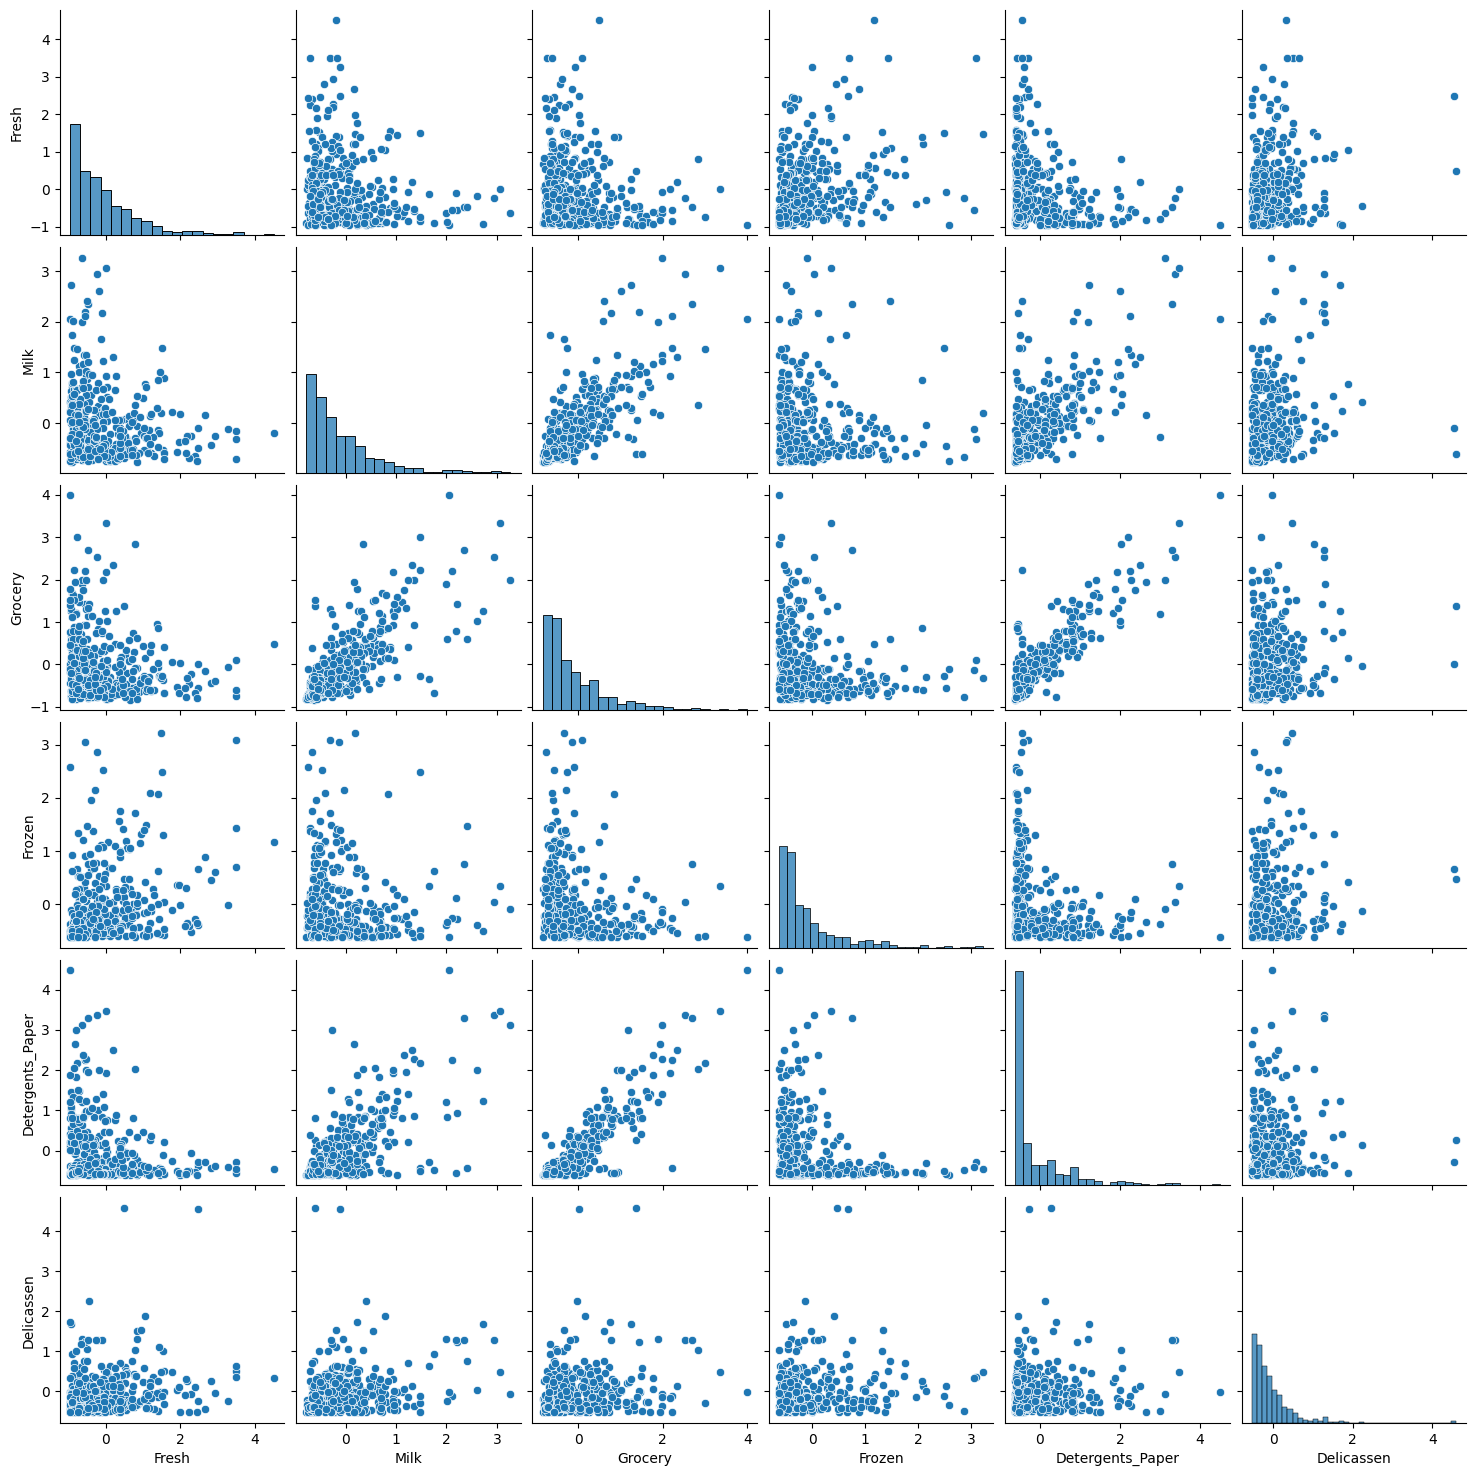

Log: 



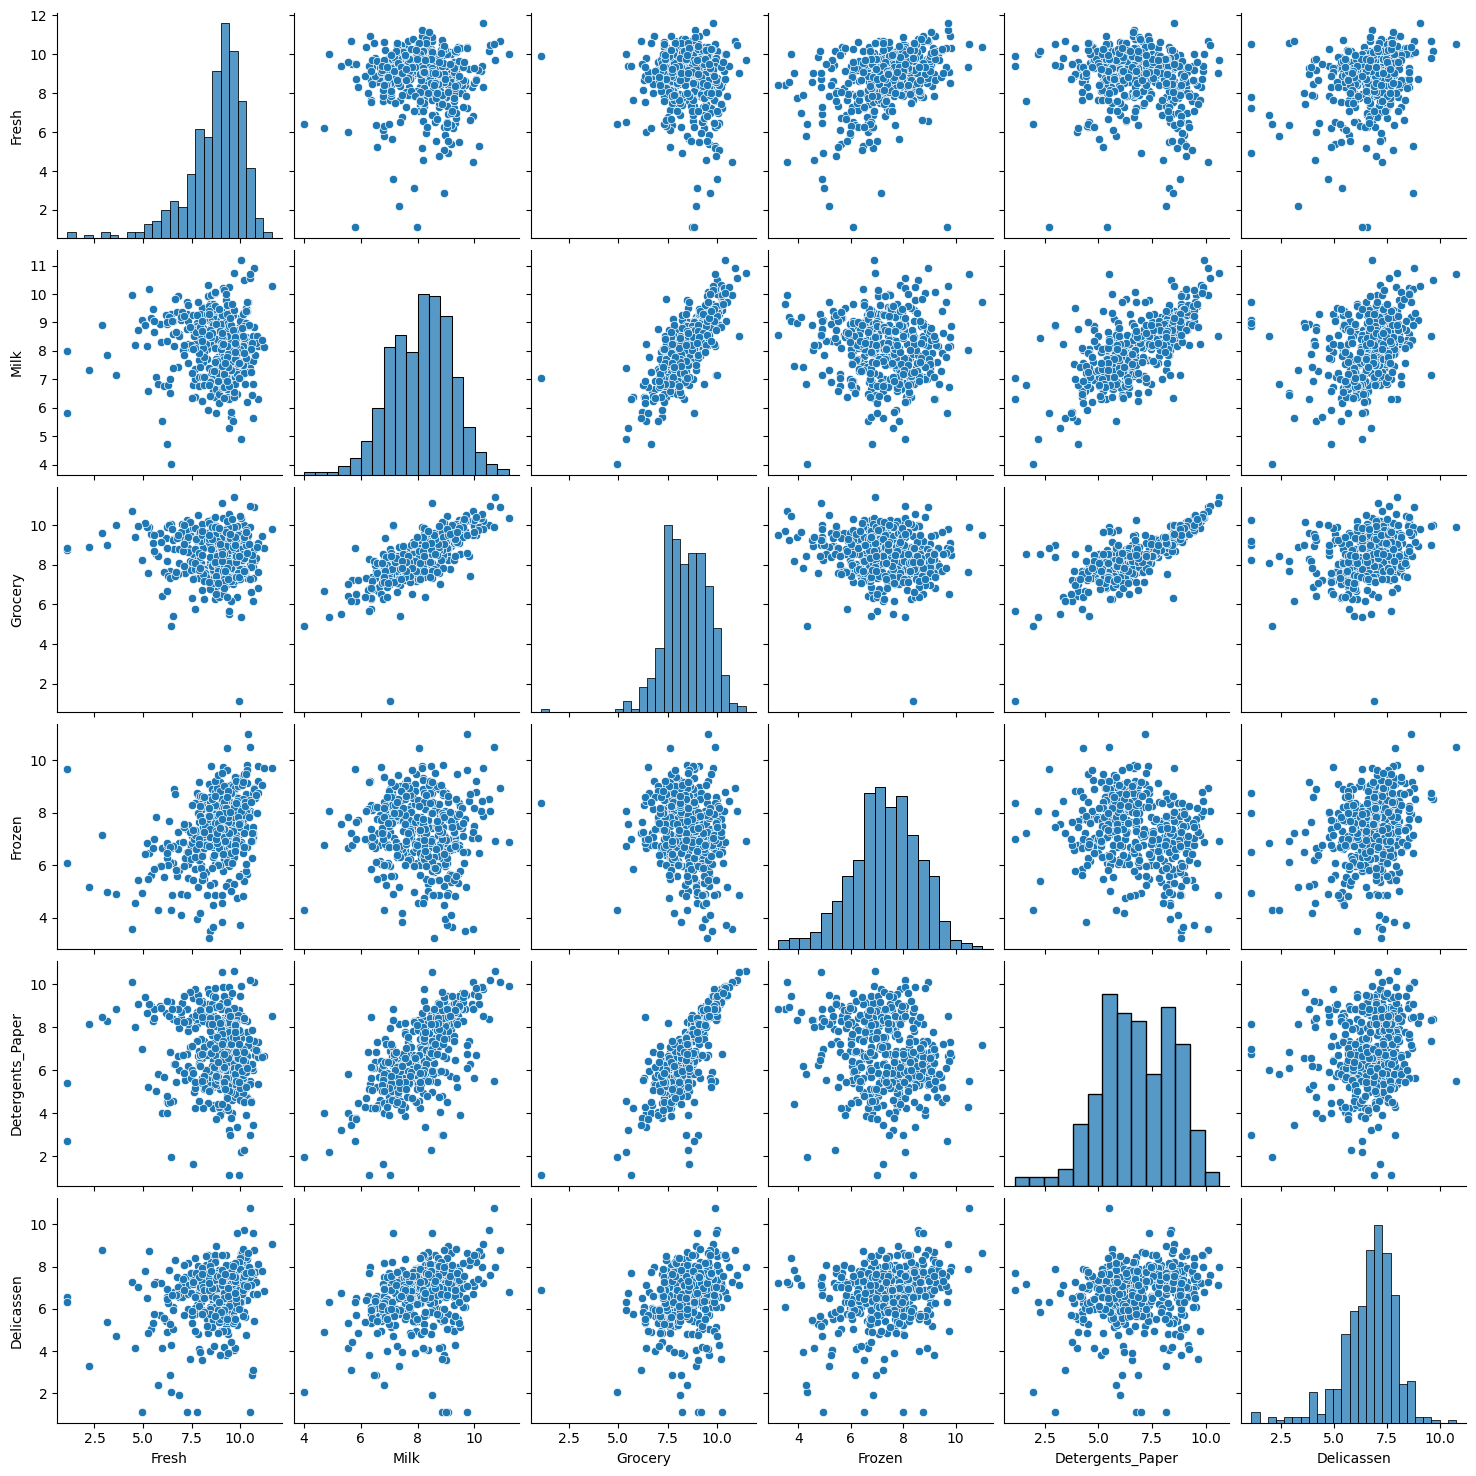

Z-score: 



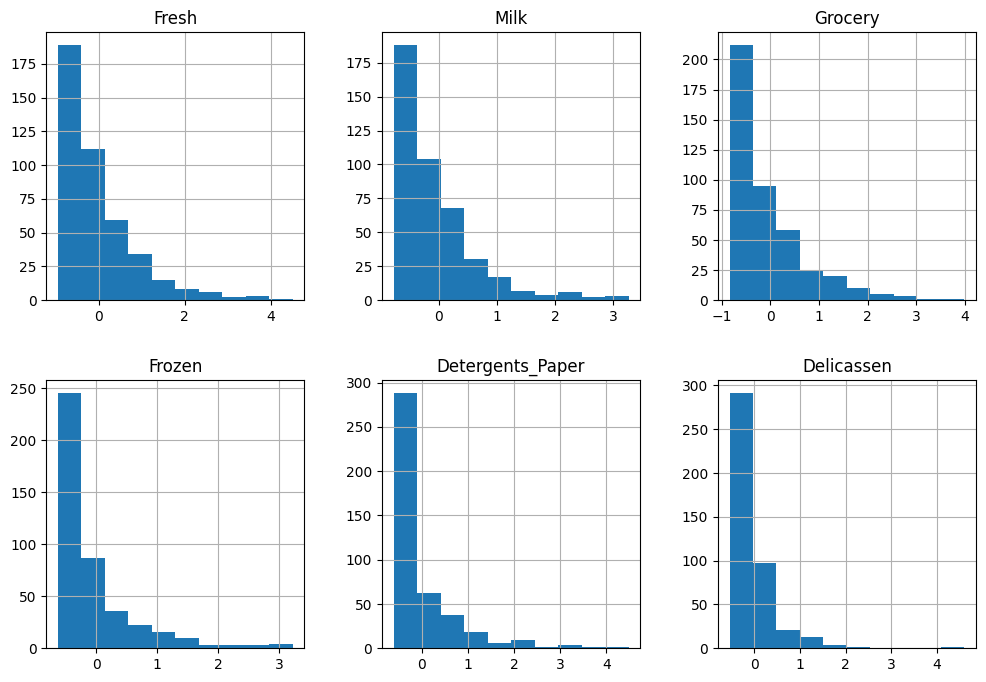

Log: 



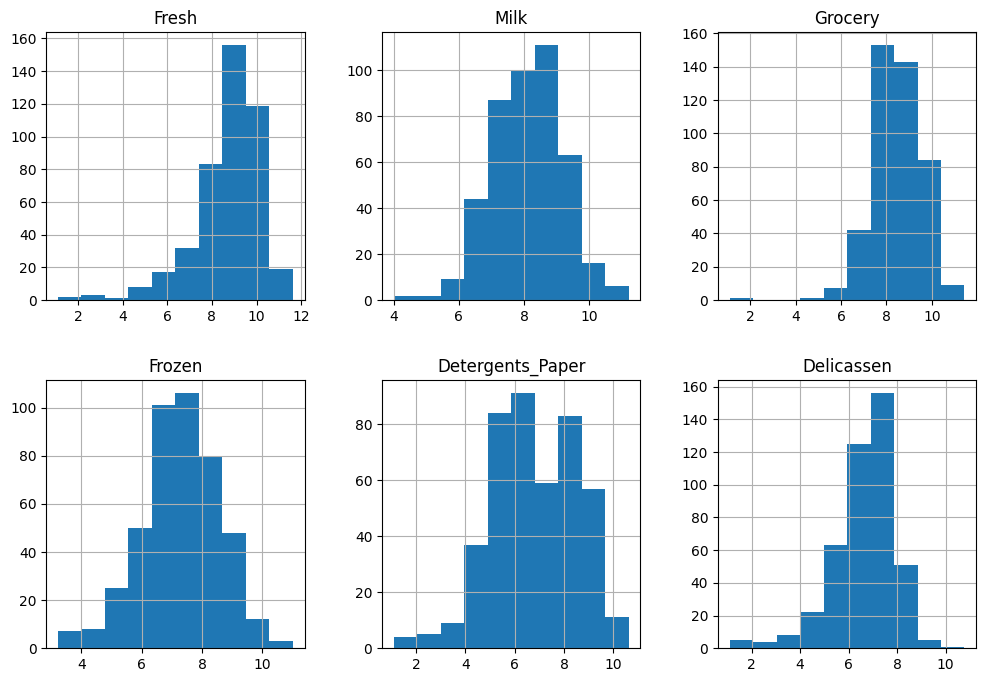

In [ ]:
print("Z-score: \n")
sns.pairplot(scaled_df)
plt.show()

print("Log: \n")
sns.pairplot(log_transformed_df)
plt.show()

print("Z-score: \n")
scaled_df.hist(bins=10, figsize=(12, 8), layout=(2, 3))
plt.show()

print("Log: \n")
log_transformed_df.hist(bins=10, figsize=(12, 8), layout=(2, 3))
plt.show()


#### Statistical Tests

One of the clustering algorithms, Gaussian Mixture Models, works best if the features are normally distributed.

One method to determine if data is normally distributed is a [Shapiro-Wilk Test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test). Perform a Shapiro-Wilk test on each column of the both the Z-score scaled data and the log-transformed data and print out if the test says that the column is normally distributed at a significance level of 0.05.

---
**Hints**
- [`scipy.stats.shapiro()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)


In [ ]:
from scipy.stats import shapiro

featured_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


for col in featured_cols:

    print(f"\n\n{col}:")

    statistic, p_value = shapiro(log_transformed_df[col])
    print(f"Log Transformed - {col}: Statistic={statistic:.3f}, p-value={p_value:.3f}")
    if p_value > 0.05:
        print("Sample appears to be normally distributed (fail to reject H0)\n")
    else:
        print("Sample does not appear to be normally distributed (reject H0)\n")


    statistic, p_value = shapiro(scaled_df[col])
    print(f"Scaled - {col}: Statistic={statistic:.3f}, p-value={p_value:.3f}")
    if p_value > 0.05:
        print("Sample appears to be normally distributed (fail to reject H0)\n")
    else:
        print("Sample does not appear to be normally distributed (reject H0)\n")




Fresh:
Log Transformed - Fresh: Statistic=0.890, p-value=0.000
Sample does not appear to be normally distributed (reject H0)

Scaled - Fresh: Statistic=0.835, p-value=0.000
Sample does not appear to be normally distributed (reject H0)



Milk:
Log Transformed - Milk: Statistic=0.994, p-value=0.085
Sample appears to be normally distributed (fail to reject H0)

Scaled - Milk: Statistic=0.798, p-value=0.000
Sample does not appear to be normally distributed (reject H0)



Grocery:
Log Transformed - Grocery: Statistic=0.965, p-value=0.000
Sample does not appear to be normally distributed (reject H0)

Scaled - Grocery: Statistic=0.798, p-value=0.000
Sample does not appear to be normally distributed (reject H0)



Frozen:
Log Transformed - Frozen: Statistic=0.990, p-value=0.004
Sample does not appear to be normally distributed (reject H0)

Scaled - Frozen: Statistic=0.738, p-value=0.000
Sample does not appear to be normally distributed (reject H0)



Detergents_Paper:
Log Transformed - Dete

## Models

Compare Gaussian Mixture Models and Agglomerative Clustering algorithms on both preprocessed data sets using the Silhouette score, Calinski-Harabasz score, and Davies-Bouldin score. Only use the following 3 features: `['Frozen', 'Detergents_Paper', 'Delicassen']`. Results will be visualized on a 3-D scatter plot.

_Note: do not do a train/test split. Evaluate the clustering results on the entire data set._


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
import plotly.express as px

cluster_cols = ['Frozen', 'Detergents_Paper', 'Delicassen']

def plot_3d_clustering(data, labels, columns=cluster_cols):
    """
    Function to create a 3D plot to visualize clustering results using Plotly.

    Parameters:
    - data: The DataFrame containing the data.
    - labels: The array of cluster labels.
    - columns: A list of three column names to plot.
    """
    col1, col2, col3 = columns

    # Create a DataFrame with the selected columns and the cluster labels
    plot_data = data[[col1, col2, col3]].copy()
    plot_data['Cluster'] = labels.astype(str)

    # Create a 3D scatter plot using Plotly
    fig = px.scatter_3d(plot_data, x=col1, y=col2, z=col3, color='Cluster', opacity=0.7,
                        title='3D Clustering Visualization',
                        labels={col1: col1, col2: col2, col3: col3, 'Cluster': 'Cluster'})

    fig.show()

#### Gaussian Mixture Model

Do a grid search across the the following number of clusters (`n_components`) for the `GaussianMixture` algorithm. Evaluate each clustering result using the three metrics mentioned above. Do this for both the z-score scaled and log transformed data sets. Pick the hyperparameters and data set that give best result and plot it using the `plot_3d_clustering()` function defined above.


_Hyperparameters_
```
{
    'n_components': [2, 3, 4, 5, 6],
}
```

---
**Hints**

_Modeling_
- [`sklearn.mixture.GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

_Metrics_

- [`sklearn.metrics.silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
- [`sklearn.metrics.calinski_harabasz_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)
- [`sklearn.metrics.davies_bouldin_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html)




In [ ]:


def evaluate_clustering(data, model):
    labels = model.fit_predict(data)
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return silhouette, calinski_harabasz, davies_bouldin, num_clusters



# Hyperparameter grids
gmm_param_grid = {'n_components':   [2, 3, 4, 5, 6]}

results = []

# Loop through GMM hyperparameters
for n_components in gmm_param_grid['n_components']:
    gmm = GaussianMixture(n_components=n_components)

    # Evaluate on Z-score standardized dataset
    sil, ch, db, num_clusters = evaluate_clustering(scaled_df[cluster_cols], gmm)
    results.append({
        'Dataset': 'Z-score',
        'Algorithm': 'GMM',
        'Params': {'n_components': n_components},
        'Silhouette Score': sil,
        'Calinski-Harabasz Index': ch,
        'Davies-Bouldin Index': db,
        'Number of Clusters': num_clusters
    })

    # Evaluate on Log-transformed dataset
    sil, ch, db, num_clusters = evaluate_clustering(log_transformed_df[cluster_cols], gmm)
    results.append({
        'Dataset': 'Log',
        'Algorithm': 'GMM',
        'Params': {'n_components': n_components},
        'Silhouette Score': sil,
        'Calinski-Harabasz Index': ch,
        'Davies-Bouldin Index': db,
        'Number of Clusters': num_clusters
    })
results_df = pd.DataFrame(results)
results_df
gmm = GaussianMixture(n_components=3)
labels = gmm.fit_predict(log_transformed_df[cluster_cols])
plot_3d_clustering(log_transformed_df, labels, cluster_cols)

#### Agglomerative Clustering

Do a grid search across the the following hyperparameters for the `AgglomerativeClustering` algorithm. Evaluate each clustering result using the three metrics mentioned above. Do this for both the z-score scaled and log transformed data sets. Pick the hyperparameters and data set that give best result and plot it using the `plot_3d_clustering()` function defined above.


_Hyperparameters_
```
{
    'n_clusters': [2, 3, 4, 5, 6],
    'linkage': ['complete', 'single']
}
```

---
**Hints**

_Modeling_
- [`sklearn.cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

_Metrics_

- [`sklearn.metrics.silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
- [`sklearn.metrics.calinski_harabasz_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)
- [`sklearn.metrics.davies_bouldin_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html)




In [ ]:
# Hyperparameter grids for Agglomerative Clustering
agglo_param_grid = {'n_clusters': [10, 5, 14, 15, 6], 'linkage': ['complete', 'single']}

results = []

# Loop through Agglomerative Clustering hyperparameters
for n_clusters in agglo_param_grid['n_clusters']:
    for linkage in agglo_param_grid['linkage']:
        agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)

        # Evaluate on Z-score standardized dataset
        sil, ch, db, num_clusters = evaluate_clustering(scaled_df, agglo)
        results.append({
            'Dataset': 'Z-score',
            'Algorithm': 'Agglomerative Clustering',
            'Params': {'n_clusters': n_clusters, 'linkage': linkage},
            'Silhouette Score': sil,
            'Calinski-Harabasz Index': ch,
            'Davies-Bouldin Index': db,
            'Number of Clusters': num_clusters
        })

        # Evaluate on Log-transformed dataset
        sil, ch, db, num_clusters = evaluate_clustering(log_transformed_df, agglo)
        results.append({
            'Dataset': 'Log',
            'Algorithm': 'Agglomerative Clustering',
            'Params': {'n_clusters': n_clusters, 'linkage': linkage},
            'Silhouette Score': sil,
            'Calinski-Harabasz Index': ch,
            'Davies-Bouldin Index': db,
            'Number of Clusters': num_clusters
        })

results_df = pd.DataFrame(results)
results_df

agglo = AgglomerativeClustering(n_clusters=2, linkage='single')
labels = agglo.fit_predict(log_transformed_df[cluster_cols])
plot_3d_clustering(log_transformed_df, labels, cluster_cols)

## Conclusions

In the data visualization of each of the 2 preprocessed data sets, what are the main differences you notice between the scaling methods? Also, What variables appear to be correlated with each other based on these graphs?**



I noticed that Z-score scaling produces a more distinct number of clusters, while log transformation does not. With Z-score scaling, the data points also appear more spread out, whereas with log transformation, the data points are closer to the origin. There appears to be a strong correlation between Grocery and Detergents_Paper.

**Do the results of the Shapiro-Wilk tests generally match with what you see in the graphs of each variables distribution - do they look normally distributed and does the Shapiro-Wilk test say it they are normally distributed or not? Also, what other methods or tests could be done to test for normality?**


The Shapiro-Wilk test results do not align with what is observed in the graphs. Although the results suggests that the sample is not normally distributed, some features, such as Milk and Frozen after log transformation, appear to be normally distributed. To further assess normality, a Quantile-Quantile (Q-Q) plot can be used, as it provides a visual method for evaluating normality across all sample sizes.

**Which algorithm, hyperparameters, and data set gave the best clustering result? Give reasons for why it is "best" _(better metrics, more visually separated clusters, etc.)_**

I observed that the Gaussian Mixture Model with hyperparameters [2, 3, 4, 5, 6] provided the best results. Visually, the clusters are much more separated compared to the Agglomerative Clustering algorithm. Additionally, the Gaussian Mixture Model assigns more data points to clusters, resulting in more defined groupings than those produced by Agglomerative Clustering.

**If you continued to try improving the clustering results, what would be your next steps?**






I would try other clustering methods, such as DBSCAN, to compare which yields better results. Additionally, I would experiment with different hyperparameters to determine which configuration produces more meaningful clusters